In [1]:
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rc('pdf', fonttype=42)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

# Timeline

In [4]:
_ = (
    pd.read_csv(
        'rehydrated_tweets_count_by_day.csv',
        parse_dates=['day'],
        index_col=['day', 'lang']
   )
    ['count']
    .unstack('lang', fill_value=0)
)

_['total'] = _.sum(axis=1)
_ = _[['lv', 'ru', 'en', 'total']]

timeline = _

In [5]:
timeline.head()

lang,lv,ru,en,total
day,,,,
2017-04-15,1307,365,134,1956
2017-04-16,1464,338,191,2205
2017-04-17,1354,289,176,1985
2017-04-18,2776,382,313,3653
2017-04-19,3137,453,305,4119


In [6]:
'Average tweet number per day: {:.0f}'.format(timeline['total'].mean())

'Average tweet number per day: 3204'

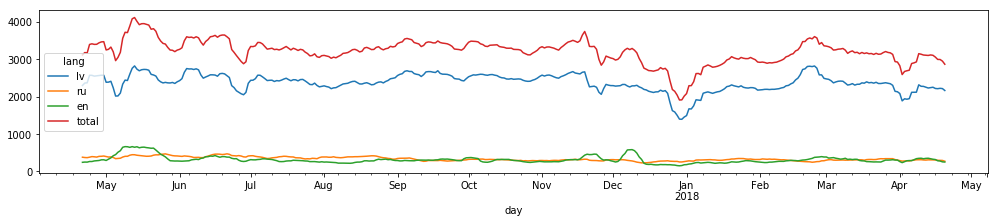

In [7]:
_ = timeline.rolling(window=7).mean().plot(figsize=(17, 3))

_.figure.savefig('rehydrated_tweets_count_by_day.pdf')

# Source statistics

In [8]:
sources = (
    pd.read_csv(
        'rehydrated_tweets_source_counts.csv',
        index_col=[
            'source_pretty',
            'total_count', 'total_share', 'tracked_source_share',
            'other_lang_count', 'other_lang_share',
            'lang',
        ],
        usecols=[
            'source_pretty',
            'total_count', 'total_share', 'tracked_source_share',
            'other_lang_count', 'other_lang_share',
            'lang',
            'source_lang_count', 'source_lang_share'
        ],
    )
    .unstack('lang', fill_value=0)
)

In [9]:
sources = (
    sources.reorder_levels([1, 0], axis=1)
    .reset_index()
    .set_index('source_pretty').sort_values('total_count', ascending=False)[
        [
            'total_count', 'total_share', 'tracked_source_share',
            'lv', 'ru', 'en',
            'other_lang_count', 'other_lang_share',
        ]
    ]
    .sort_values('total_count', ascending=False)
)

In [10]:
sources

lang                total_count total_share tracked_source_share  \
                                                                   
source_pretty                                                      
Twitter Web Client       409355       34.4%                52.0%   
Twitter for Android      194359       16.4%                 8.5%   
Twitter for iPhone       176795       14.9%                13.7%   
TweetDeck                 91899        7.7%                91.6%   
TVNET Login               48938        4.1%                96.7%   
dlvr.it                   39193        3.3%                98.4%   
Facebook                  31166        2.6%                95.1%   
Foursquare                28991        2.4%                 0.0%   
Instagram                 23046        1.9%                 1.8%   
SKATIES                   19015        1.6%                98.2%   

lang                               lv                                  ru  \
                    source_lang_count source_lang_share source_lang_count   
source_pretty                                                               
Twitter Web Client             340726             83.2%             13043   
Twitter for Android            132385             68.1%             19545   
Twitter for iPhone             105144             59.5%             29666   
TweetDeck                       90098             98.0%                66   
TVNET Login                     22681             46.3%             25684   
dlvr.it                         38713             98.8%               123   
Facebook                        11899             38.2%             17711   
Foursquare                      22762             78.5%               208   
Instagram                        8347             36.2%              2242   
SKATIES                         19003             99.9%                 0   

lang                                                 en                    \
                    source_lang_share source_lang_count source_lang_share   
source_pretty                                                               
Twitter Web Client               3.2%             33370              8.2%   
Twitter for Android             10.1%             28672             14.8%   
Twitter for iPhone              16.8%             26975             15.3%   
TweetDeck                        0.1%              1247              1.4%   
TVNET Login                     52.5%                15              0.0%   
dlvr.it                          0.3%               117              0.3%   
Facebook                        56.8%               424              1.4%   
Foursquare                       0.7%              1978              6.8%   
Instagram                        9.7%              7591             32.9%   
SKATIES                             0                 0                 0   

lang                other_lang_count other_lang_share  
                                                       
source_pretty                                          
Twitter Web Client             22216             5.4%  
Twitter for Android            13757             7.1%  
Twitter for iPhone             15010             8.5%  
TweetDeck                        488             0.5%  
TVNET Login                      558             1.1%  
dlvr.it                          240             0.6%  
Facebook                        1132             3.6%  
Foursquare                      4043            13.9%  
Instagram                       4866            21.1%  
SKATIES                           12             0.1%

In [11]:
sources.to_latex('figures/rehydrated_tweets_source_counts.tex')

# Language usage 

In [12]:
_ = pd.read_csv('rehydrated_tweets_lang_usage.csv', index_col='rnum')

_['Language Uniformity Score'] = (_[['lv', 'ru', 'en']].max(axis=1) / _[['lv', 'ru', 'en']].sum(axis=1)).round(2)

lang_usage = _

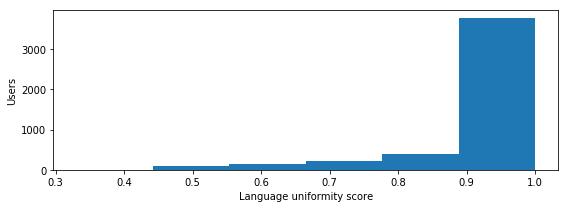

In [13]:
_ = lang_usage['Language Uniformity Score'].plot.hist(bins=6, figsize=(8, 3))

_.set(xlabel="Language uniformity score", ylabel="Users")
_.figure.tight_layout()

_.figure.savefig('rehydrated_tweets_lang_usage.pdf')

In [14]:
lang_usage.sort_values('Language Uniformity Score').head()

,lv,ru,en,total,Language Uniformity Score
rnum,,,,,
3591,7,7,7,30,0.33
1752,13,16,14,74,0.37
4130,7,3,7,24,0.41
1432,15,20,14,96,0.41
844,48,60,36,182,0.42


# Language preference

## Monolingual

In [15]:
(
    lang_usage[
        (lang_usage[['lv', 'ru', 'en']] == 0).sum(axis='columns') == 2
    ]
    [['lv', 'ru', 'en']] > 0
).sum(axis='rows')

lv    1463
ru     135
en     281
dtype: int64

## Multilingual

In [16]:
(
    lang_usage[
        (lang_usage[['lv', 'ru', 'en']] > 0).sum(axis='columns') > 1
    ]
    [['lv', 'ru', 'en']]
    .replace(0, np.nan)
    .rank(axis='columns', method='min', ascending=False)
    .apply(lambda c: c.value_counts(), axis='rows')
)

,lv,ru,en
1.0,2034,311,443
2.0,498,210,2105
3.0,82,247,108


# Topics

In [17]:
relevance_judgments_count_by_day = (
    pd.read_csv(
        'relevance_judgments_count_by_day.csv',
        index_col=['day', 'topic_id'],
        parse_dates=['day'],
    )['count']
    .unstack('topic_id', fill_value=0)
)

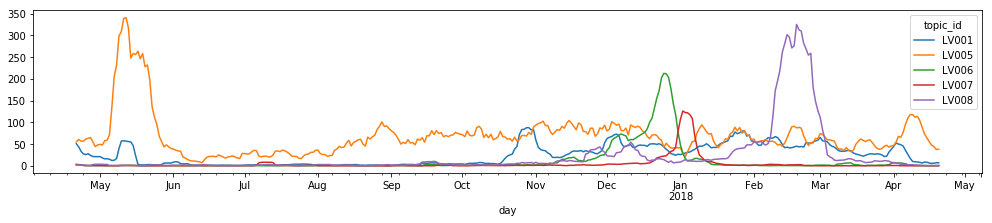

In [18]:
(
    relevance_judgments_count_by_day[['LV001', 'LV005', 'LV006', 'LV007', 'LV008']]
    .rolling(window=7).mean()
    .plot(figsize=(17, 3))
);

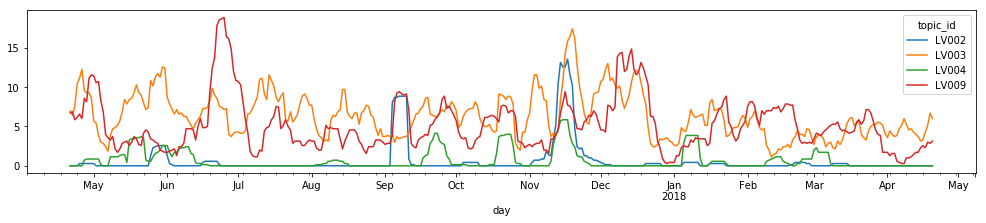

In [19]:
(
    relevance_judgments_count_by_day[['LV002', 'LV003', 'LV004', 'LV009']]
    .rolling(window=7).mean()
    .plot(figsize=(17, 3))
);

In [20]:
_ = (
    pd.read_csv(
        'relevance_judgments_lang_pref_by_day.csv',
        index_col=['day', 'topic_id'],
        parse_dates=['day'],
    )
)

_.columns = pd.MultiIndex.from_tuples(
    [
        ('Counts', 'Total'),
        ('Counts', 'lv, ru, en'),

        ('Tweets', 'lv'),
        ('Tweets', 'ru'),
        ('Tweets', 'en'),

        ('Users', 'lv'),
        ('Users', 'ru'),
        ('Users', 'en'),
    ],
    names=['Type', 'Language']
)
relevance_judgments_lang_pref_by_day = _

In [21]:
relevance_judgments_lang_pref_by_day.head()

Type                Counts            Tweets             Users            
Language             Total lv, ru, en     lv    ru    en    lv    ru    en
day        topic_id                                                       
2017-04-15 LV001        72         71   0.90  0.06  0.04  0.83  0.07  0.10
2017-04-16 LV001        70         70   0.97  0.01  0.01  0.94  0.03  0.03
2017-04-17 LV001        65         61   0.84  0.15  0.02  0.79  0.15  0.06
2017-04-18 LV001        31         31   0.90  0.10  0.00  0.90  0.09  0.01
2017-04-19 LV001        19         19   0.68  0.11  0.21  0.83  0.11  0.07

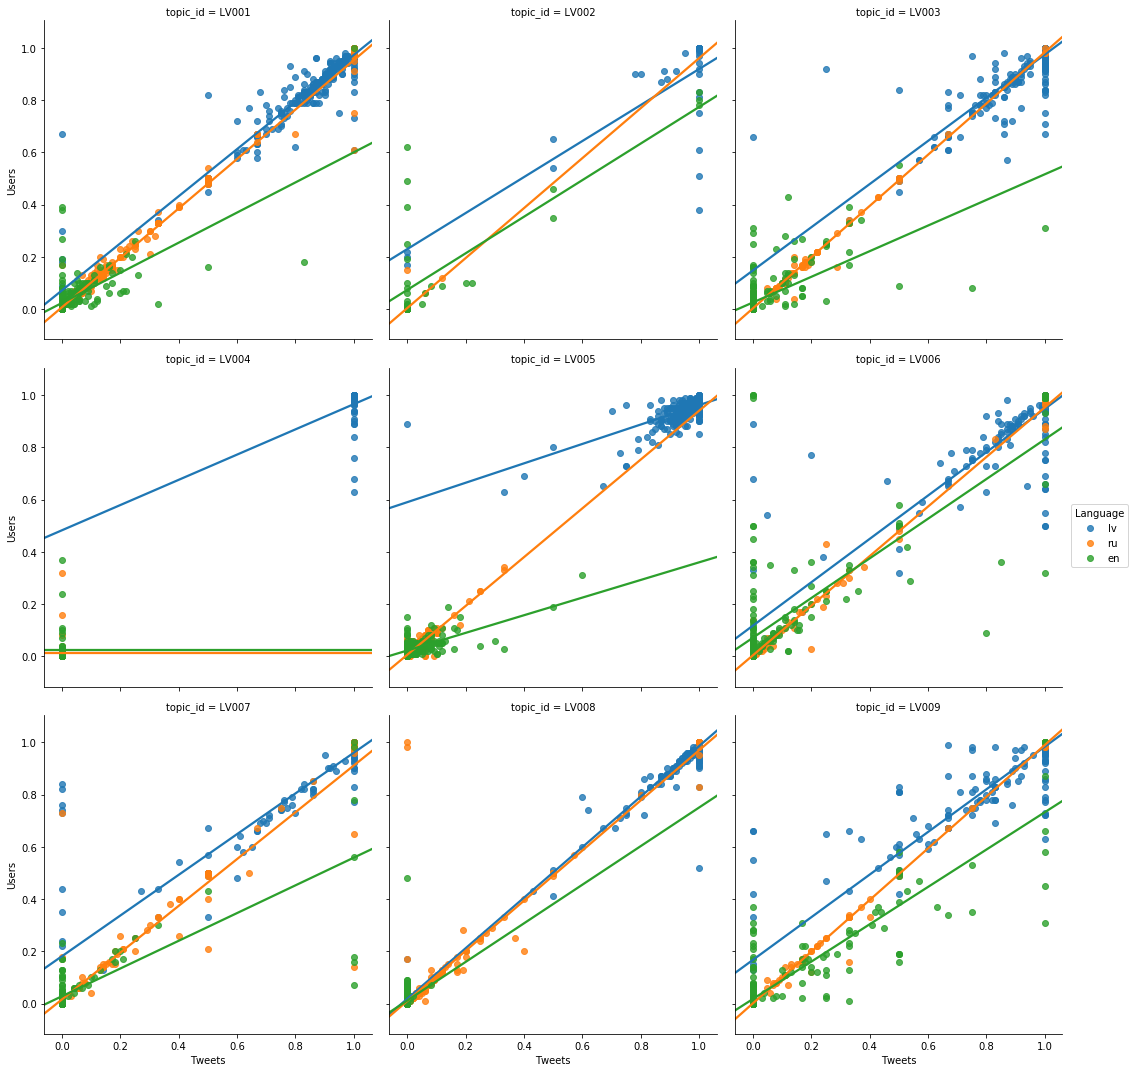

In [22]:
_ = relevance_judgments_lang_pref_by_day[['Tweets', 'Users']].stack().reset_index(['topic_id', 'Language'])

sns.lmplot(
    x='Tweets', y='Users',
    hue='Language', hue_order=['lv', 'ru', 'en'],
    col='topic_id', col_wrap=3,
    data=_,
    ci=None,
);

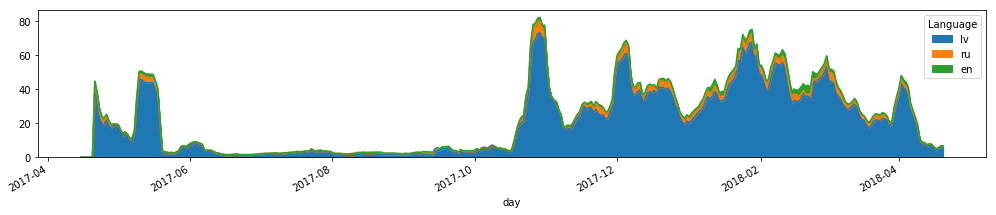

In [23]:
_ = relevance_judgments_lang_pref_by_day.loc[(slice(None), 'LV001'), :].reset_index('topic_id')

(
    _['Tweets']
    .multiply(
        _['Counts', 'lv, ru, en'],
        axis='rows',
    )
    .rolling(window=7).mean()
    .plot.area(figsize=(17, 3))
);

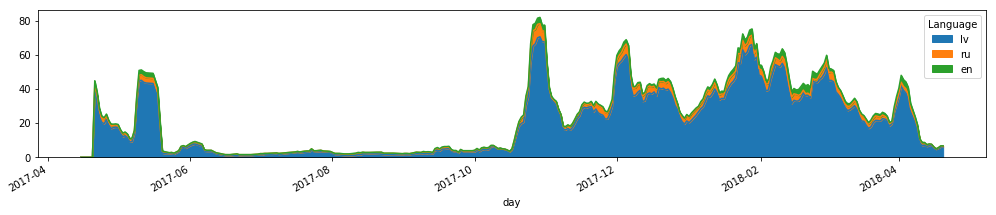

In [24]:
_ = relevance_judgments_lang_pref_by_day.loc[(slice(None), 'LV001'), :].reset_index('topic_id')

(
    _['Users']
    .multiply(
        _['Counts', 'lv, ru, en'],
        axis='rows',
    )
    .rolling(window=7).mean()
    .plot.area(figsize=(17, 3))
);

## Topics 2

In [25]:
_ = pd.read_csv(
    'relevance_judgments_lang_pref.csv',
    index_col=['topic_id', 'day'],
)[['r_lv', 'r_ru', 'r_en']]


_.columns = ['lv', 'ru', 'en']

relevance_judgments_lang_pref = _

In [26]:
relevance_judgments_lang_pref.loc[['LV005']].head()

lv   ru    en
topic_id day                                 
LV005    2017-04-15 00:00:00  0.91  0.0  0.09
         2017-04-16 00:00:00  0.91  0.0  0.09
         2017-04-16 00:00:00  0.91  0.0  0.09
         2017-04-16 00:00:00  1.00  0.0  0.00
         2017-04-16 00:00:00  0.91  0.0  0.09

### Topics 3

In [27]:
relevance_judgments_count_by_day.divide?

In [28]:
_ = pd.read_csv(
    'relevance_judgments_lang_pref_by_user.csv',
    index_col=['topic_id', 'rnum'],
)

_.columns = pd.MultiIndex.from_tuples(
    [
        ('User', 'lv'),
        ('User', 'ru'),
        ('User', 'en'),
        ('User', 'total'),

        ('Topic', 'lv'),
        ('Topic', 'ru'),
        ('Topic', 'en'),
        ('Topic', 'total'),

    ],
    names=['Type', 'Language']
)

_ = _.stack('Type')
_ = _[['lv', 'ru', 'en']].divide(_['total'], axis='rows').round(2)

# _ = _.unstack('Type').stack('Language')
# _.reset_index(['Language', 'topic_id'], inplace=True, keep=True)

_ = _.unstack('Type')

_.columns = ['t_lv', 'u_lv', 't_ru', 'u_ru', 't_en', 'u_en']

relevance_judgments_lang_pref_by_user = _#[['u_lv', 'u_ru', 'u_en', 't_lv', 't_ru', 't_en']]

_.head()

t_lv  u_lv  t_ru  u_ru  t_en  u_en
topic_id rnum                                    
LV001    1      1.0  1.00   0.0   0.0   0.0   0.0
         2      1.0  1.00   0.0   0.0   0.0   0.0
         3      1.0  1.00   0.0   0.0   0.0   0.0
         4      1.0  0.99   0.0   0.0   0.0   0.0
         5      1.0  0.99   0.0   0.0   0.0   0.0

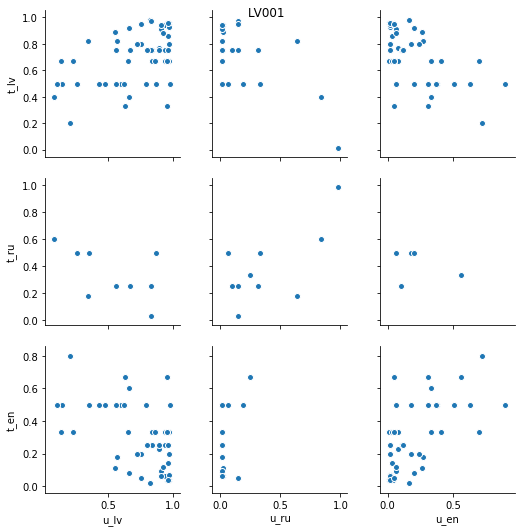

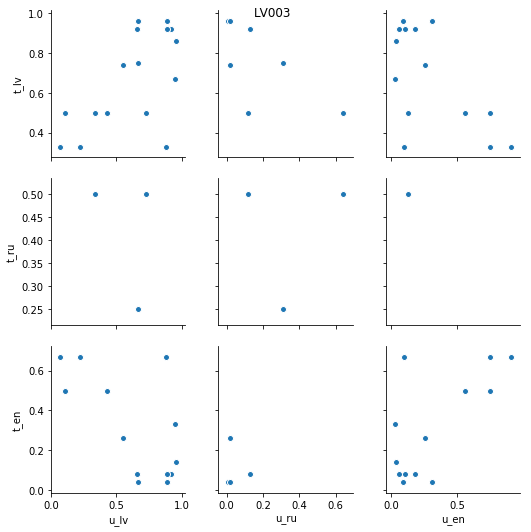

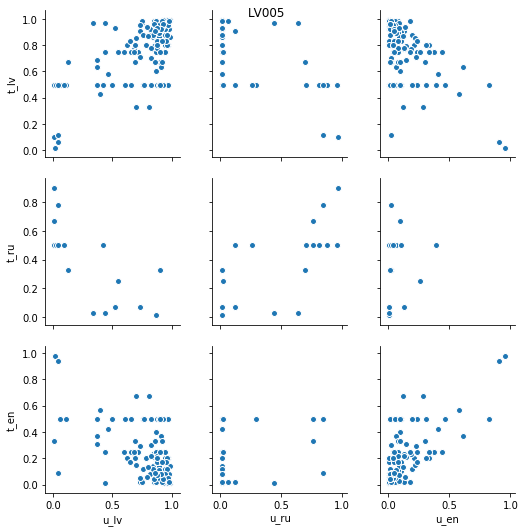

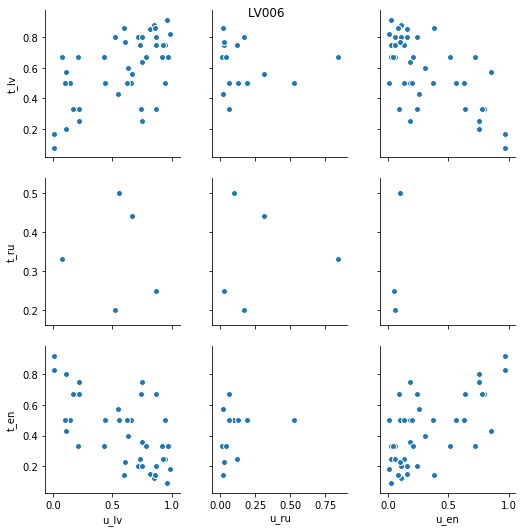

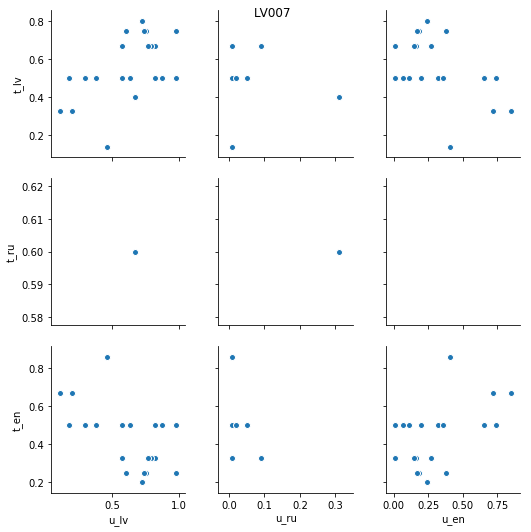

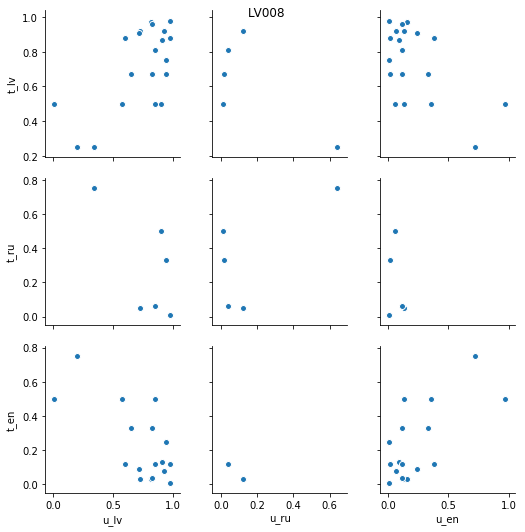

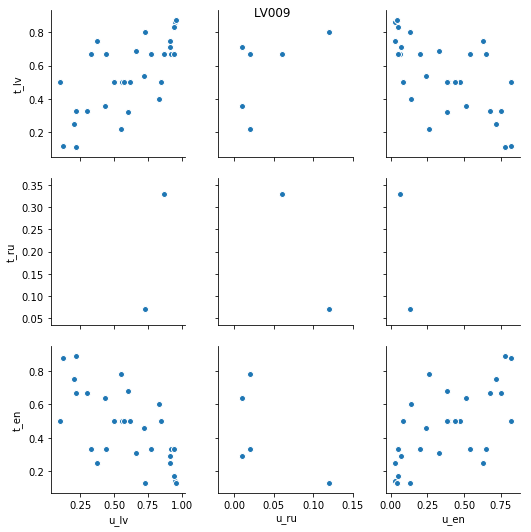

In [29]:
for topic in (
    'LV001',
    'LV003',
    'LV005',
    'LV006', 'LV007', 'LV008', 'LV009'
):

    g = sns.pairplot(
        x_vars=[
            'u_lv', 'u_ru', 'u_en'
        ],
        y_vars=[
            't_lv', 't_ru', 't_en'
        ],
        data=relevance_judgments_lang_pref_by_user.loc[topic].replace({0: np.nan, 1: np.nan}),
        kind='scatter',
    )
    
    g.fig.suptitle(topic)
    g.fig.savefig(f'lang_perf_by_user_{topic}.pdf')